In [1]:
import sys
import random
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import callbacks
import glob

from PIL import Image
import glob

import tensorflow as tf
import time
import cv2

In [2]:
!which python3
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

/home/tomZhou/anaconda3/bin/python3
Name: /physical_device:GPU:0   Type: GPU


In [3]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
#TRAIN_PATH = './dataset/training/'
#TEST_PATH = './dataset/testing/'
TRAIN_NUM = 1700
TEST_NUM = 300
sample_dir = "../big_dataset/train/img/"
mask_dir = "../big_dataset/train/mask/"
test_sample_dir = "../testing/sample/"
test_mask_dir = "../testing/mask/"


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

#### sample_ids
* contain all the names of sample and mask data IN TRAINING SET
* mask_ids = sample_ids + "_matte.png"

#### test_sample_ids
* contain all the names of sample and mask data IN TESTING SET
* test_mask_ids = test_sample_ids + "_matte.png"


In [4]:
#Get the filenames of training and testing data
sample_ids = next(os.walk(sample_dir))[2]
test_sample_ids = next(os.walk(test_sample_dir))[2]
print(sample_ids[:10])
print(test_sample_ids[:10])

['1803151818-00007601.png', '1803151818-00018027.png', '1803151818-00002588.png', '1803151818-00020594.png', '1803151818-00012341.png', '1803151818-00013603.png', '1803151818-00015026.png', '1803151818-00010138.png', '1803151818-00011274.png', '1803151818-00000936.png']
['00086.png', '00005.png', '00291.png', '00184.png', '00046.png', '00038.png', '00170.png', '00224.png', '00203.png', '00264.png']


### Building the model here

In [5]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [6]:
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
inputs = layers.Input(shape=img_shape)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = None
model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

W0730 02:54:34.185142 139959061603712 deprecation.py:506] From /home/tomZhou/anaconda3/envs/CondaTF/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [8]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [9]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [10]:
save_model_path = './weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

### Use a custom data generator

In [11]:
# sample_dir = "../big_dataset/train/img/"
# mask_dir = "../big_dataset/train/mask/"
# test_sample_dir = "../big_dataset/test/img/"
# test_mask_dir = "../big_dataset/test/mask"

batch_size = 10

class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
    def __init__(self, train_im_path=sample_dir,train_mask_path=mask_dir,
                 augmentations=None, batch_size=batch_size,img_size=512, n_channels=3, shuffle=True, mode="train"):
#         'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.mode = mode

        self.on_epoch_end()

    def __len__(self):
#         'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)
        
#         for i in range(batch_size):
#             print("Img come out", X[i,150:160, 150:160])
            
        # First generate data
        #Then rescale them
 
        if self.augment is None:
            return X.astype(np.float32)/255,np.array(y).astype(np.float32)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                aug_im = augmented['image']
                aug_mask = augmented['mask']
#                 print("augmented image data type:", aug_im.dtype)
#                 print("augmented mask data type:", aug_mask.dtype)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
                
                return_im = np.array(im)
                return_mask = np.array(mask)
                return_im = return_im.astype(np.float32)/255
                return_mask = return_mask.astype(np.float32)/255
                
            return return_im, return_mask

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))
        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = cv2.imread(im_path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            if self.mode == "train":
                pass
            else:
                mask_path = mask_path[:-4]+"_matte.png"             
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
#             print("img data type:", im.dtype)
#             print("mask data type: ", mask.dtype)
#             print("img feed in: ", im[150:160, 150:160])
#             print("mask feed in: ", mask[150:160, 150:160])
            
            if len(im.shape)==2:
                print("shape before:", im.shape)
                im = np.repeat(im[...,None],3,2)
                print("shape after:",im.shape)
                
#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))
#             X[i,] = resize(im,(800, 500))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
#             print("img after reszie:", im.dtype)
#             print("mask after resize: ", mask.dtype)

            #NOTE that after skimage.transform.resize, the pixel value range of
            #the mask is already between 0 and 1. No NEED TO DIVIDE by 255
            # BUT NOW USING cv2.resize(), the values are between 0 and 255
            y[y>64] = 255
            y[y <64] = 0
        
        return X,y #They are both in float64 now because I used the rubbish skimage

In [12]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.7),
    OneOf([
        RandomGamma(gamma_limit=(90,100), p=0.5),
#         RandomBrightness(),
        MotionBlur(blur_limit=5,p=0.5)
         ], p=0.6),
    OneOf([
        ElasticTransform(p =0.5),
        GridDistortion(num_steps=2, distort_limit=0.3,p=0.5),
#         OpticalDistortion(distort_limit=2, shift_limit=0.2),
        ], p=0.8)
#     ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
#     ToFloat(max_value=1)
],p=1)

In [12]:
# train_datagen.fit(X_train, seed = 4)


-----------------------------------------

(512, 512, 3)
(512, 512, 1)


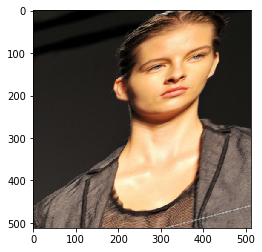

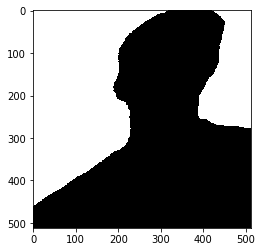

(512, 512, 3)
(512, 512, 1)


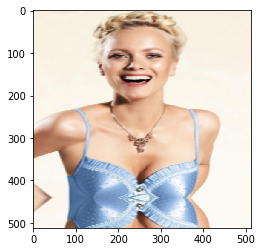

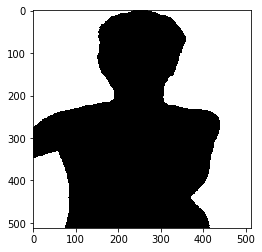

(512, 512, 3)
(512, 512, 1)


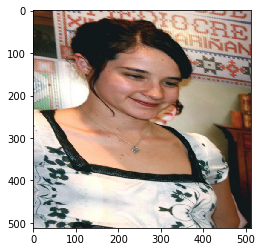

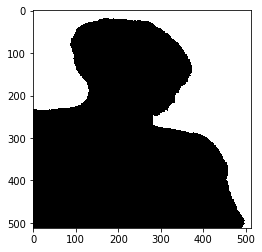

(512, 512, 3)
(512, 512, 1)


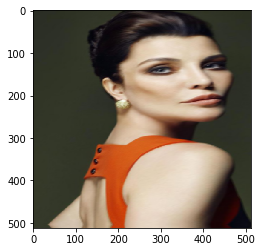

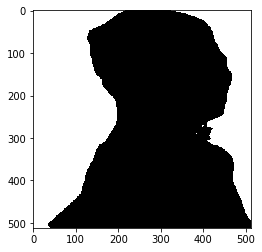

(512, 512, 3)
(512, 512, 1)


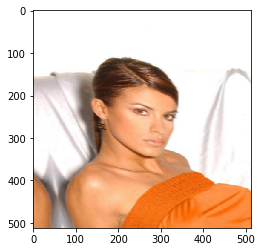

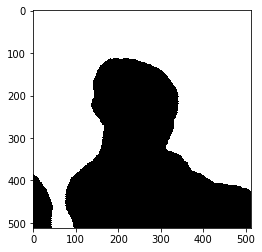

(512, 512, 3)
(512, 512, 1)


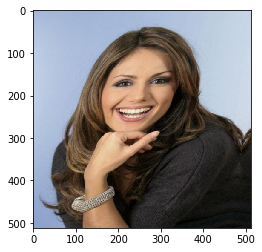

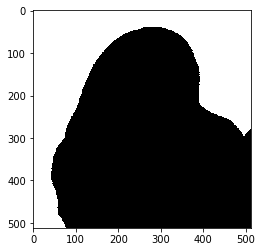

(512, 512, 3)
(512, 512, 1)


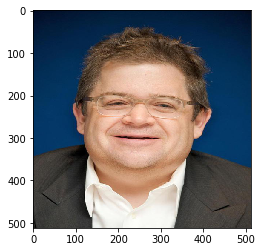

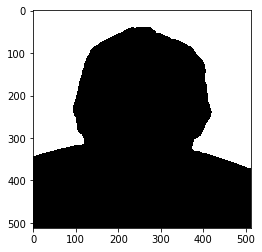

(512, 512, 3)
(512, 512, 1)


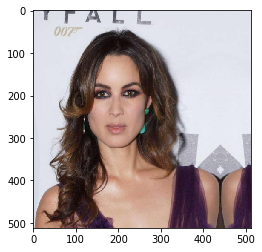

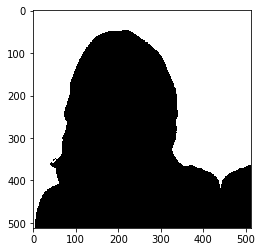

(512, 512, 3)
(512, 512, 1)


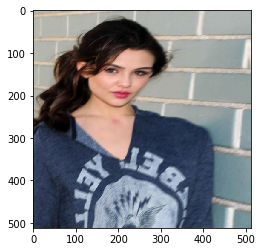

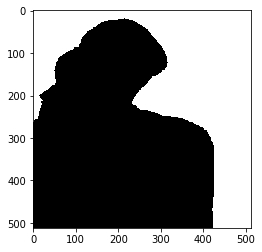

(512, 512, 3)
(512, 512, 1)


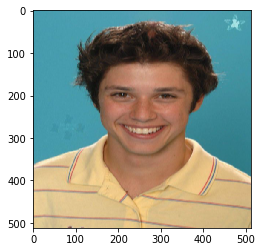

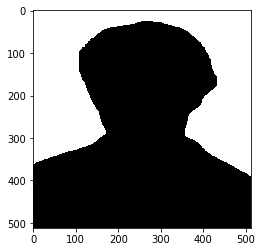

In [13]:
a = DataGenerator(batch_size=10,shuffle=False, augmentations=AUGMENTATIONS_TRAIN)
gen_images,gen_masks = a.__getitem__(0)
max_images = 10
grid_width = 2

print()
print("-----------------------------------------")
print()
for i in range(10):
#     img = gen_images[i].astype(np.uint8)

    img = gen_images[i]
    gt = gen_masks[i]

    print(img.shape)
    print(gt.shape)
    
#     print("img dtype:")
#     print(img.dtype)
    
#     print("mask dtype:")
#     print(gt.dtype)
    
    
    plt.imshow(img)
#     print(img[200:230, 200:240])
    plt.show()

    plt.imshow(gt.squeeze(), cmap = "Greys")
#     print(gt.squeeze()[200:230, 200:240])
    plt.show()
    
# fig, axs_2 = plt.subplots(grid_height, grid_width, figsize=(10, 10))
# for i,(im, mask) in enumerate(zip(images,masks)):
#     ax = axs_2[int(i / grid_width), i % grid_width]
#     ax.imshow(im)    
#     ax.axis('off')
# plt.suptitle("Example Training Pictures")

In [13]:
# Here the two generators are instantiated to fit in the model.fit_generator()
batchSize = 10
print(sample_dir)
print(mask_dir)
print(test_sample_dir)
print(test_mask_dir)
training_generator = DataGenerator(batch_size= batchSize, augmentations=AUGMENTATIONS_TRAIN,img_size=IMG_HEIGHT, mode = "train")

validation_generator = DataGenerator(batch_size=batchSize,train_im_path = test_sample_dir ,
                                     train_mask_path=test_mask_dir,
                                     augmentations=None,
                                     img_size=IMG_HEIGHT,
                                    mode = "test")


../big_dataset/train/img/
../big_dataset/train/mask/
../testing/sample/
../testing/mask/


## Compile or load the model

In [14]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

W0730 02:54:51.030578 139959061603712 deprecation.py:323] From /home/tomZhou/anaconda3/envs/CondaTF/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
# !ls -al
model = models.load_model("./maybe_overfitting.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

W0730 02:54:51.081521 139959061603712 deprecation.py:506] From /home/tomZhou/anaconda3/envs/CondaTF/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 02:54:51.082368 139959061603712 deprecation.py:506] From /home/tomZhou/anaconda3/envs/CondaTF/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 02:54:51.084453 139959061603712 deprecation.py:506] From /home/tomZhou/anaconda3/envs/CondaTF/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: call

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
# history = model.fit(X_train, Y_train, batch_size = batchSize, epochs = 5, 
#                     shuffle =True, validation_data = (X_test, Y_test))

In [17]:
history = model.fit_generator(training_generator,
                    epochs=4,
                    validation_data = validation_generator,
                    callbacks=[cp],
                    verbose =1,
                    workers=6
                    )


Epoch 1/4


ResourceExhaustedError: OOM when allocating tensor with shape[8,512,512,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node Mkl2Tf/_1089}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
model.save("./maybe_overfitting.hdf5")

### See how the trained model performs 
The model is trained for 25 epochs with no shuffled data and achieved 0.143 val_loss. After training for 10 epochs with shuffled data, the model achieved   val_loss.

In [ ]:
model.evaluate_generator(validation_generator,  verbose =1)

In [ ]:
# Plot training & validation accuracy values

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [ ]:
# #There must be an alternative to doing this
predictions = model.predict_generator(validation_generator, steps = 1) # NOTE THAT the input values should be normalized to be between 0 and 1

In [ ]:
print(predictions.shape)

for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(np.uint8)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
#     plt.imshow(Y_train[i][:,:,0], cmap = 'Greys')
    plt.show()
    
    
# for i in range(IMG_WIDTH):
#     for j in range(IMG_HEIGHT):
#         print(img[i,j], end = ' ')
        
# for i in range(predictions.shape[0]):
#     plt.imshow(Y_test[i], cmap= 'Greys')
#     plt.show()
#     plt.imshow(255*predictions[i].reshape([IMG_WIDTH,IMG_HEIGHT]))
#     time.sleep(0.4)

### Now see how the model which had the best val_acc performs

In [ ]:
print(batchSize)
print(save_model_path)

In [ ]:
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [ ]:
# #There must be an alternative to doing this
predictions = model.predict(X_test[:10]) # NOTE THAT the input values should be normalized to be between 0 and 1

In [ ]:
print(Y_test.shape)
print(predictions.shape)

for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(int)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
    plt.imshow(Y_test[i][:,:,0], cmap = 'Greys')
    plt.show()
    

#### Below is a test to see how the two generators are performing image augmentation

In [ ]:
!ls -a
!rm -rf ./train
!rm -rf ./train_masks
!mkdir ./train
!mkdir ./train_masks

In [ ]:
# ! ls -a ./train

In [ ]:
# os.listdir("./train")

In [ ]:
# import cv2
# img = cv2.imread('img_3_7408.png')
# print(type(img))
# for img_id in os.listdir("./train"):
#     img = cv2.imread(img_id)
#     print(img_id)
#     print(type(img))
#     plt.imshow(img)
#     plt.show()